**TITLE: EARLY-STAGE PREDICTION OF ALZHEIMER'S DISEASE USING DEEP LEARNING ON STRUCTURAL MRI DATA**

## Import the necessary libraries

In [22]:
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dataset='/content/drive/MyDrive/archive (1)/Alzheimer_s Dataset/train'
test_dataset='/content/drive/MyDrive/archive (1)/Alzheimer_s Dataset/test'

In [4]:
# combine both classes
all_folders =[train_dataset,test_dataset]

## initialize counters
total_images = 0
classes=set()

## count images and get class names
for folder in all_folders:
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path): ## it must be a folder
            classes.add(class_name)
            total_images += len(os.listdir(class_path))
## print the elements
print(f'total images:{total_images}')
print(f'classes:{len(classes)}')
print(f'classes:{classes}')


total images:6401
classes:4
classes:{'MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented'}


In [6]:
total_dir='/content/drive/MyDrive/Alzheimer_dataset/dir'

## ensure the directory exist
os.makedirs(total_dir,exist_ok=True)

## combine dataset
all_folders=[train_dataset,test_dataset]

##  initialize both dataset
total_images=0
classes =set()

##  copy imges new directory
for folder in all_folders:
    for class_name in os.listdir(folder):
        class_path=os.path.join(folder,class_name)
        if os.path.isdir(class_path):
            classes.add(class_name)
            ## create class folder in the new directory
            new_class=os.path.join(total_dir,class_name)
            os.makedirs(new_class,exist_ok=True)
            ## copy images to the new directory
            for image_name in os.listdir(class_path):
                image_path=os.path.join(class_path,image_name)
                new_image_path=os.path.join(new_class,image_name)
                shutil.copy(image_path,new_image_path)
                total_images+=1

print(f'total images:{total_images}')
print(f'classes:{len(classes)}')
print(f'classes:{classes}')

total images:6401
classes:4
classes:{'MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented'}


In [7]:
split_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split'
## define the diir
train_dir = os.path.join(split_data, 'train')
test_dir = os.path.join(split_data, 'test')
val_dir = os.path.join(split_data, 'valid')
## checking if the directoey exist
for  folder in[train_dir,test_dir,val_dir]:
    os.makedirs(folder,exist_ok=True)
## initialise counters
total_images=0
classes = set()


In [8]:


# Define dataset paths
original_dataset = "/content/drive/MyDrive/Alzheimer_dataset/dir"
output_dir = "/content/drive/MyDrive/Alzheimer_dataset/dir_split"
##
# Define split directories
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
valid_dir = os.path.join(output_dir, "valid")

# Ensure output directories exist##
for folder in [train_dir, test_dir, valid_dir]:
    os.makedirs(folder, exist_ok=True)

# Initialize counters
total_images = 0
classes = set()

# Split dataset
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if os.path.isdir(class_path):  # Ensure it's a folder
        classes.add(class_name)

        # Create class subfolders in train, test, and valid directories
        train_class_path = os.path.join(train_dir, class_name)
        test_class_path = os.path.join(test_dir, class_name)
        valid_class_path = os.path.join(valid_dir, class_name)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        os.makedirs(valid_class_path, exist_ok=True)

        # Get all images and shuffle
        images = os.listdir(class_path)
        random.shuffle(images)

        # Split into 80-10-10
        train_split = int(0.8 * len(images))
        test_split = int(0.9 * len(images))  # 90% point (test + valid)

        train_images = images[:train_split]
        test_images = images[train_split:test_split]
        valid_images = images[test_split:]

        # Copy images to respective folders
        for image in train_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(train_class_path, image))

        for image in test_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(test_class_path, image))

        for image in valid_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(valid_class_path, image))

        total_images += len(images)

# Print results
print(f"Total Images: {total_images}")
print(f"Total Classes: {len(classes)}")
print(f"Class Names: {classes}")
print("Dataset successfully split into Train (80%), Test (10%), and Validation (10%)")


Total Images: 6401
Total Classes: 4
Class Names: {'MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented'}
Dataset successfully split into Train (80%), Test (10%), and Validation (10%)


In [28]:
def count_images(split_data):
    split_count = {}  # Initialize split_count as an empty dictionary
    for class_name in os.listdir(split_data):
        class_path = os.path.join(split_data, class_name)
        if os.path.isdir(class_path):
            split_count[class_name] = len(os.listdir(class_path))
    return split_count
# counting total element in split data
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
valid_counts = count_images(valid_dir)

## print result
print ('\nTrain Dataset:')
for class_name, count in train_counts.items():
    print(f'{class_name}:{count} images')
print ('\nTest Dataset:')
for class_name, count in test_counts.items():
    print(f'{class_name}:{count} images')
print ('\nValid Dataset:')
for class_name, count in valid_counts.items():
    print(f'{class_name}:{count} images')


Train Dataset:
VeryMildDemented:1792 images
MildDemented:716 images
ModerateDemented:51 images
NonDemented:2560 images

Test Dataset:
VeryMildDemented:224 images
MildDemented:90 images
ModerateDemented:6 images
NonDemented:320 images

Valid Dataset:
VeryMildDemented:224 images
MildDemented:90 images
ModerateDemented:7 images
NonDemented:321 images


In [10]:
train_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/train'
test_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/test'
valid_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/valid'

In [12]:
def get_info_on_the_dataset (dataset_path):
  classes =os.listdir(dataset_path)
  total_images= sum([len(os.listdir(os.path.join(dataset_path,class_name))) for class_name in classes])
  return classes,total_images


total_train, total_class_train=get_info_on_the_dataset(train_data)
total_test,total_class_test=get_info_on_the_dataset(test_data)
total_valid,total_class_valid=get_info_on_the_dataset(valid_data)
## print each element
print(f'classes:{total_class_train},total train images:{total_train}')
print(f'classes:{total_class_test},total test images:{total_test}')
print(f'tclasses:{total_class_valid},total test images:{total_valid}')

classes:5119,total train images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
classes:640,total test images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
tclasses:642,total test images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']


## loading the train dataset

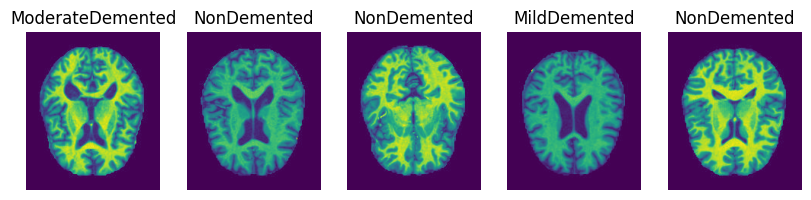

In [25]:
## get classes
classes = [d for d in os.listdir(train_data) if os.path.isdir(os.path.join(train_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(train_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1) # Creating 5 subplots in a 1x5 grid
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## test dataset

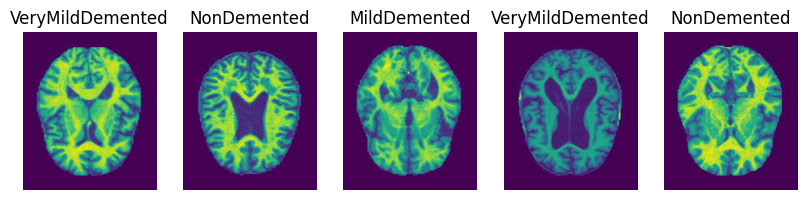

In [26]:
## get classes
classes = [d for d in os.listdir(test_data) if os.path.isdir(os.path.join(test_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(test_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1) # Creating 5 subplots in a 1x5 grid
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## valid dataset

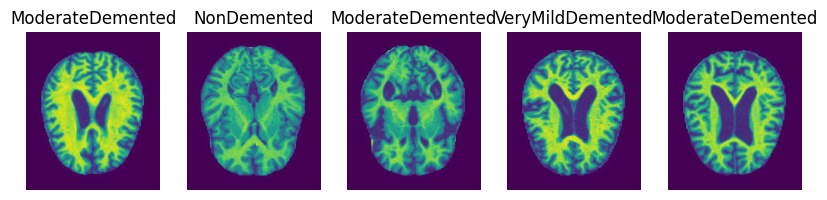

In [27]:
## get classes
classes = [d for d in os.listdir(valid_data) if os.path.isdir(os.path.join(valid_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(valid_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1) # Creating 5 subplots in a 1x5 grid
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()